In [ ]:
import dask
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from eofs.xarray import Eof

import warnings
warnings.filterwarnings("ignore")

In [2]:
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (
        (time - time.isel({time_dim: 0}))
        .astype("timedelta64[s]")
        .astype("int64")
        .astype("float64")
    )

In [3]:
def linear_detrend(
    obj: xr.DataArray | xr.Dataset, time_dim: str = "time"
) -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)

    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()  # (time, ...)
        t_b = t.broadcast_like(da)  # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid  # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")

    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

In [4]:
def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = (
        detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    )
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [ ]:
# Open downloaded netCDF dataset from Copernicus
ds = xr.open_dataset("data_stream-moda_stepType-avgua.nc")
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 612, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 5kB 1974-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver      (valid_time) <U4 10kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 920MB ...
    tcwv        (valid_time, latitude, longitude) float32 920MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-14T20:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# Compute anomalies by detrending and deseasonalizing data
detr = linear_detrend(ds[["sst", "tcwv"]], time_dim="valid_time")
anom, z = monthly_anom_and_z(
    detr, time_dim="valid_time", base_period=("1979-01-01", "2024-12-01")
)
z = z.drop_vars(["number", "expver", "month"])
z

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 612, latitude: 521, longitude: 721)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 5kB 1974-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
Data variables:
    sst         (valid_time, latitude, longitude) float32 920MB nan nan ... nan
    tcwv        (valid_time, latitude, longitude) float32 920MB 0.9837 ... 0....

In [ ]:
coslat = np.cos(np.deg2rad(z.coords["latitude"].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(z["sst"], weights=wgts)

In [ ]:
# Find the first 5 EOFs
nEOFS = 5
eofs = solver.eofsAsCorrelation(neofs=nEOFS)

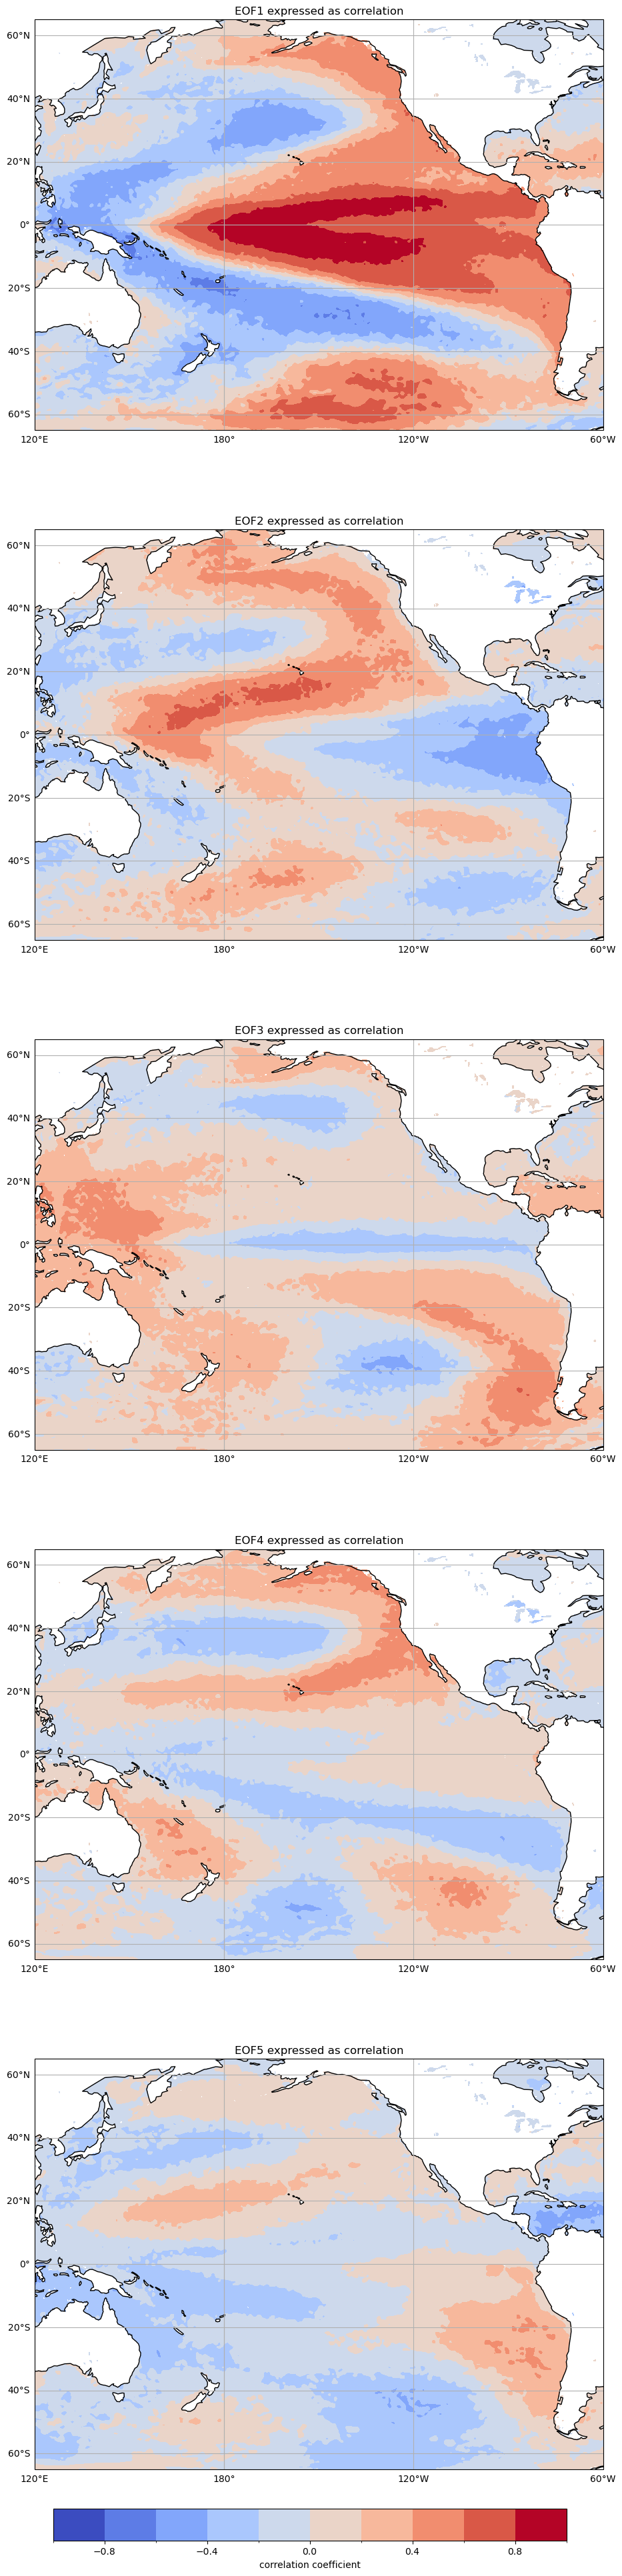

In [ ]:
# Plot the first 5 EOFs expressed as correlation
clevs = np.linspace(-1, 1, 11)

fig, axes = plt.subplots(
    nEOFS,
    figsize=(11, 48),
    subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=210)),
)

for i in range(nEOFS):
    fill = eofs[i].plot.contourf(
        ax=axes[i],
        cmap="coolwarm",
        levels=clevs,
        add_colorbar=False,
        transform=ccrs.PlateCarree(),
    )
    gl = axes[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    axes[i].coastlines()
    axes[i].set_title(f"EOF{i+1} expressed as correlation")

cbar_ax = fig.add_axes([0.15, 0.09, 0.7, 0.01])  # left, bottom height ,length, width
cb = fig.colorbar(fill, orientation="horizontal", cax=cbar_ax)
cb.set_label("correlation coefficient")
plt.show()

In [ ]:
# Find fractional variance
varFrac = solver.varianceFraction()

(9.525782288007513e-16, 0.20517993927001954)

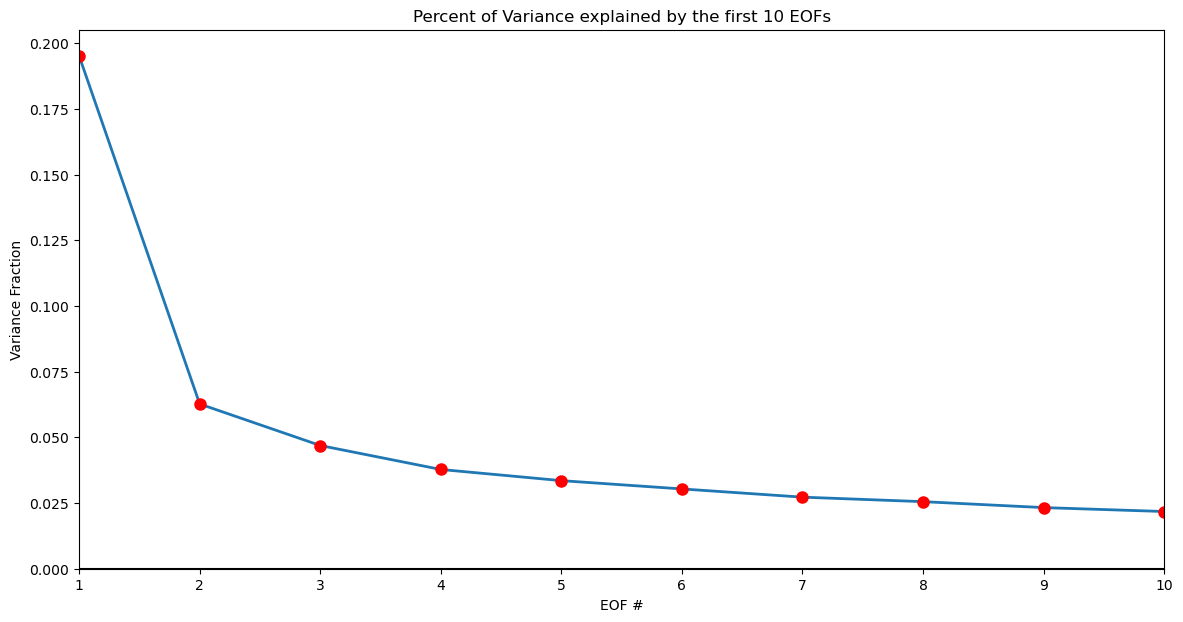

In [ ]:
# Plot fractional variance of the first 10 EOFs
fig, ax = plt.subplots(figsize=(14, 7))
eof_num = range(1, 11)
ax.plot(eof_num, varFrac[0:10], linewidth=2)
ax.plot(eof_num, varFrac[0:10], linestyle="None", marker="o", color="r", markersize=8)
ax.axhline(0, color="k")
ax.set_xticks(eof_num)
ax.set_title("Percent of Variance explained by the first 10 EOFs")
ax.set_xlabel("EOF #")
ax.set_ylabel("Variance Fraction")
ax.set_xlim(1, 10)
ax.set_ylim(np.min(varFrac), np.max(varFrac) + 0.01)

In [ ]:
# Reconstruct SST using the first 5 EOFs
recon = solver.reconstructedField(5)
recon

<xarray.DataArray 'sst' (valid_time: 612, latitude: 521, longitude: 721)> Size: 920MB
array([[[        nan,         nan,         nan, ...,  0.27950242,
          0.30490506,  0.3247325 ],
        [        nan,         nan,         nan, ...,  0.31390193,
          0.34131625,  0.3611043 ],
        [        nan,         nan,         nan, ...,  0.31991223,
          0.34293064,  0.35711306],
        ...,
        [-0.2066863 , -0.20337337, -0.1988482 , ...,         nan,
                 nan,         nan],
        [-0.19168381, -0.20470645, -0.21430124, ...,         nan,
                 nan,         nan],
        [-0.18299052, -0.18937767, -0.1898148 , ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.2986399 ,
          0.32652032,  0.3486251 ],
        [        nan,         nan,         nan, ...,  0.33166543,
          0.36051175,  0.3813786 ],
        [        nan,         nan,         nan, ...,  0.3360777 ,
          0.36013263,  0.37500867],
...
        [-0.09320509, -0.08952784, -0.08552145, ...,         nan,
                 nan,         nan],
        [-0.08912033, -0.08930879, -0.08938077, ...,         nan,
                 nan,         nan],
        [-0.10136996, -0.0997929 , -0.09696195, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.2672726 ,
          0.27737695,  0.2846059 ],
        [        nan,         nan,         nan, ...,  0.27574748,
          0.28468704,  0.29115012],
        [        nan,         nan,         nan, ...,  0.28318095,
          0.29414338,  0.301033  ],
        ...,
        [-0.06967876, -0.06109197, -0.05304763, ...,         nan,
                 nan,         nan],
        [-0.05904374, -0.06599354, -0.07184696, ...,         nan,
                 nan,         nan],
        [-0.12054208, -0.12313734, -0.12608136, ...,         nan,
                 nan,         nan]]], shape=(612, 521, 721), dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 5kB 1974-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
Attributes:
    long_name:  sst_reconstructed_with_5_EOFs

In [ ]:
# Find correlation of reconstructed SST and observed SST
corr = xr.corr(recon, ds["sst"], dim="valid_time")
corr

<xarray.DataArray 'sst' (latitude: 521, longitude: 721)> Size: 2MB
array([[       nan,        nan,        nan, ..., 0.05717224, 0.05823077,
        0.0594165 ],
       [       nan,        nan,        nan, ..., 0.0582254 , 0.05797188,
        0.05829352],
       [       nan,        nan,        nan, ..., 0.05801289, 0.0593682 ,
        0.06092291],
       ...,
       [0.02220086, 0.02205877, 0.02172895, ...,        nan,        nan,
               nan],
       [0.02020306, 0.02078564, 0.02113709, ...,        nan,        nan,
               nan],
       [0.02820007, 0.02794904, 0.02613988, ...,        nan,        nan,
               nan]], shape=(521, 721), dtype=float32)
Coordinates:
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    number     int64 8B 0

Text(0.5, 1.0, 'Correlation of Reconstructed and Observed SST')

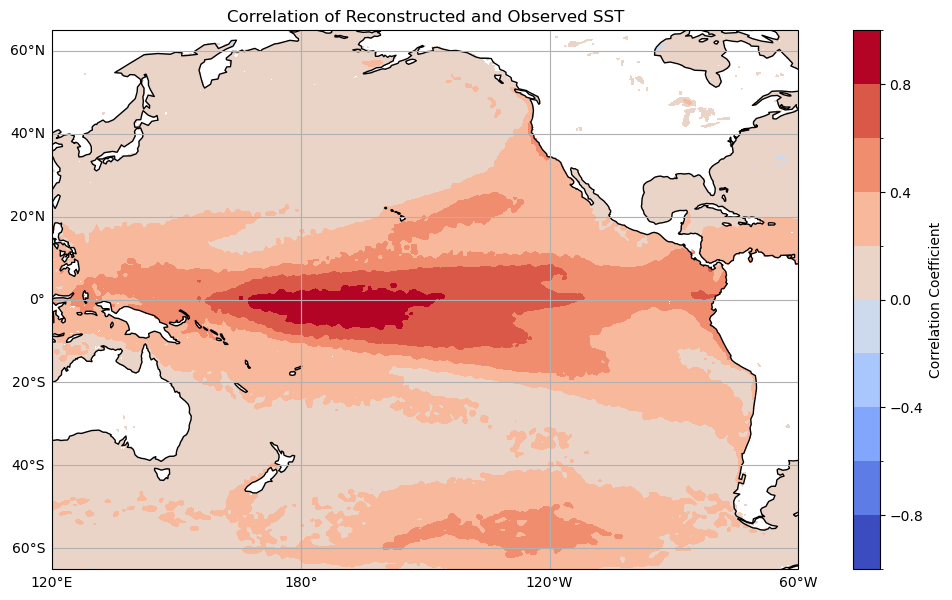

In [14]:
fig, ax = plt.subplots(
    figsize=(14, 7), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=210))
)
fill = corr.plot.contourf(
    cmap="coolwarm",
    levels=11,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Correlation Coefficient"},
)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_title("Correlation of Reconstructed and Observed SST")

In [ ]:
# Find first principal component
pc1 = solver.pcs(npcs=1, pcscaling=1)

In [ ]:
# Find correlation between the first principal component and total column water vapor
corr_tcwv = xr.corr(pc1[:, 0], z["tcwv"], dim="valid_time")
corr_tcwv

<xarray.DataArray (latitude: 521, longitude: 721)> Size: 2MB
array([[-0.04186396, -0.04329127, -0.04470705, ..., -0.06323373,
        -0.06370095, -0.06414211],
       [-0.04331344, -0.04482795, -0.0463363 , ..., -0.0637231 ,
        -0.06400032, -0.06422476],
       [-0.04519974, -0.04672753, -0.04822522, ..., -0.06393802,
        -0.06419593, -0.0643828 ],
       ...,
       [ 0.05299823,  0.05391283,  0.05477688, ..., -0.0624634 ,
        -0.06412321, -0.06547318],
       [ 0.05423228,  0.05487432,  0.05543701, ..., -0.06352831,
        -0.06215385, -0.06056961],
       [ 0.05542863,  0.05589803,  0.05623325, ..., -0.05890349,
        -0.05823661, -0.05727969]], shape=(521, 721), dtype=float32)
Coordinates:
    mode       int64 8B 0
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0

Text(0.5, 1.0, 'Correlation of SST EOF1 and Monthly Mean Column Water Vapor Anamolies')

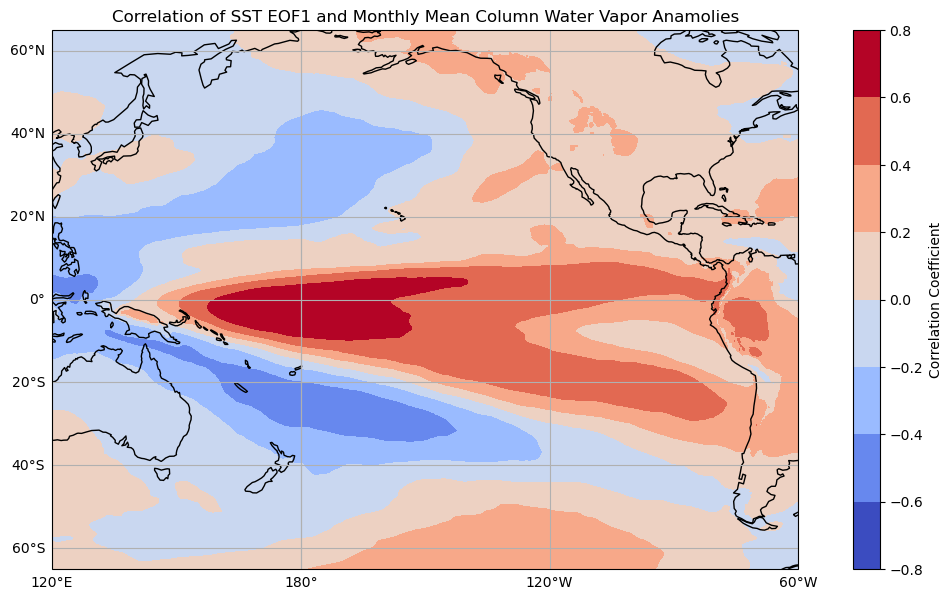

In [ ]:
# Plot correlation of EOF1 and total column water vapor anomalies
fig, ax = plt.subplots(
    figsize=(14, 7), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=210))
)
fill = corr_tcwv.plot.contourf(
    cmap="coolwarm",
    levels=11,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Correlation Coefficient"},
)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_title("Correlation of SST EOF1 and Monthly Mean Column Water Vapor Anamolies")